# Import Packages

We'll make use of the following packages:
- `numpy` is a package for scientific computing in python.
- `pandas` A powerful Python library for data manipulation and analysis.
- `seaborn` A data visualization library based on matplotlib.
- `scikit-learn` A comprehensive library for machine learning in Python.
- `kaggle` Using Kaggle API to download data.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import kagglehub
import os
import math
import matplotlib.pyplot as plt
from scipy.stats import loguniform

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, auc, roc_curve, accuracy_score, precision_score, recall_score, f1_score, RocCurveDisplay,ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, average_precision_score

from xgboost import XGBClassifier 

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

import shap
import warnings
warnings.filterwarnings("ignore")

# Download data

In [2]:
# Download latest version
path = kagglehub.dataset_download("thedevastator/predicting-credit-card-customer-attrition-with-m")

In [3]:
print(os.listdir(path))

['BankChurners.csv']


Have a quick glance of the data.

In [4]:
df = pd.read_csv(os.path.join(path, 'BankChurners.csv'))
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   CLIENTNUM                                                                                                                           10127 non-null  int64  
 1   Attrition_Flag                                                                                                                      10127 non-null  object 
 2   Customer_Age                                                                                                                        10127 non-null  int64  
 3   Gender                                                                           

Overall, the dataset has 6 non-numerical columns and 17 numerical columns.

# Functions

## Plots


### Histogram, box and bar plot

#### Numerical features

In [6]:
## bar and box plots for numerical features
def plot_box_and_hist_per_feature(dataframe,
                                  hue_col,
                                  cols_per_row=2,
                                  figsize_per_plot=(6, 5),
                                  bins=30,
                                  rotate_xticks=False):
    """
    For each numerical feature, plots a boxplot (by hue) on top and histogram below.
    
    Parameters:
    - dataframe: pandas DataFrame
    - hue_col: Target/grouping column (e.g. 'Attrition_Flag')
    - cols_per_row: Number of features per row (each has 2 subplots: box + hist)
    - figsize_per_plot: Size per feature block (width, height)
    - bins: Bins for histogram
    - rotate_xticks: Whether to rotate x-tick labels
    """

    columns = dataframe.select_dtypes(include='number').columns.tolist()
    if hue_col in columns:
        columns.remove(hue_col)

    n_features = len(columns)
    n_cols = cols_per_row
    n_rows = math.ceil(n_features / n_cols)

    fig, axes = plt.subplots(nrows=n_rows * 2, ncols=n_cols, figsize=(figsize_per_plot[0] * n_cols, figsize_per_plot[1] * n_rows * 2))
    axes = axes.reshape((n_rows * 2, n_cols))

    palette = {"Existing Customer": "#1f77b4", "Attrited Customer": "#ff7f0e"}

    for idx, col in enumerate(columns):
        row_idx = (idx // n_cols) * 2
        col_idx = idx % n_cols

        # Boxplot (top)
        sns.boxplot(data=dataframe, x=hue_col, y=col, ax=axes[row_idx][col_idx], palette=palette)
        axes[row_idx][col_idx].set_title(f'{col} - Boxplot by {hue_col}')
        axes[row_idx][col_idx].set_xlabel('')
        if rotate_xticks:
            axes[row_idx][col_idx].tick_params(axis='x', rotation=45)

        # Histogram (bottom)
        sns.histplot(data=dataframe, x=col, hue=hue_col, kde=True, bins=bins,
                     ax=axes[row_idx + 1][col_idx], stat="density", common_norm=False)
        axes[row_idx + 1][col_idx].set_title(f'{col} - Histogram by {hue_col}')
        axes[row_idx + 1][col_idx].set_ylabel('Density')
        if rotate_xticks:
            axes[row_idx + 1][col_idx].tick_params(axis='x', rotation=45)

    # Hide any unused subplots
    total_axes = n_rows * 2 * n_cols
    for i in range(idx + 1, total_axes // 2):
        axes[(i // n_cols) * 2][i % n_cols].set_visible(False)
        axes[(i // n_cols) * 2 + 1][i % n_cols].set_visible(False)

    plt.tight_layout()
    plt.show()

#### Categorical features

In [7]:
## bar and box plots for categorical features
def plot_bar_and_normalized_bars(dataframe, cat_cols, target_col, cols_per_row=2, figsize_per_plot=(6, 5), rotate_xticks=True):
    """
    For each categorical feature, plots a count bar chart on top and normalized stacked bar chart below.

    Parameters:
    - dataframe: pandas DataFrame
    - cat_cols: List of categorical columns
    - target_col: Column to group by (e.g., 'Attrition_Flag')
    - cols_per_row: Number of feature blocks per row (each block has 2 subplots)
    - figsize_per_plot: Tuple (width, height) per feature block
    - rotate_xticks: Rotate x-axis labels
    """
    n_features = len(cat_cols)
    n_cols = cols_per_row
    n_rows = math.ceil(n_features / n_cols)

    fig, axes = plt.subplots(nrows=n_rows * 2, ncols=n_cols,
                             figsize=(figsize_per_plot[0] * n_cols, figsize_per_plot[1] * n_rows * 2))
    axes = axes.reshape((n_rows * 2, n_cols))

    for idx, col in enumerate(cat_cols):
        row_idx = (idx // n_cols) * 2
        col_idx = idx % n_cols

        # Top plot: Countplot (raw counts)
        sns.countplot(data=dataframe, x=col, hue=target_col,
                    ax=axes[row_idx][col_idx],
                    order=dataframe[col].value_counts().index)

        axes[row_idx][col_idx].set_title(f'{col} - Count by {target_col}')
        axes[row_idx][col_idx].set_xlabel('')
        axes[row_idx][col_idx].set_ylabel('Count')
        if rotate_xticks:
            axes[row_idx][col_idx].tick_params(axis='x', rotation=45)

        # Add count labels to each bar
        for container in axes[row_idx][col_idx].containers:
            for bar in container:
                height = bar.get_height()
                if height > 0:
                    axes[row_idx][col_idx].text(
                        bar.get_x() + bar.get_width() / 2,
                        height + 0.01 * height,
                        f'{int(height)}',
                        ha='center', va='bottom', fontsize=8, color='black'
                    )

        # Bottom plot: Normalized bar chart
        norm_df = pd.crosstab(dataframe[col], dataframe[target_col], normalize='index')
        if 'Attrited Customer' in norm_df.columns:
            sorted_index = norm_df['Attrited Customer'].sort_values(ascending=False).index
        else:
            sorted_index = norm_df.iloc[:, 0].sort_values(ascending=False).index

        norm_df = norm_df.loc[sorted_index]
        norm_df.plot(kind='bar', stacked=True, colormap='tab10', ax=axes[row_idx + 1][col_idx])
        axes[row_idx + 1][col_idx].set_title(f'{col} - Normalized % by {target_col}')
        axes[row_idx + 1][col_idx].set_ylabel('Proportion')
        axes[row_idx + 1][col_idx].set_xlabel(col)
        axes[row_idx + 1][col_idx].legend(title=target_col)

        if rotate_xticks:
            axes[row_idx + 1][col_idx].tick_params(axis='x', rotation=45)

        # Add % labels
        for idx2, category in enumerate(norm_df.index):
            bottom = 0
            for cls in norm_df.columns:
                height = norm_df.loc[category, cls]
                axes[row_idx + 1][col_idx].text(idx2, bottom + height / 2,
                                                f'{height*100:.1f}%', ha='center', va='center',
                                                fontsize=9, color='white')
                bottom += height

    # Hide any unused plots
    total_axes = n_rows * 2 * n_cols
    for i in range(idx + 1, total_axes // 2):
        axes[(i // n_cols) * 2][i % n_cols].set_visible(False)
        axes[(i // n_cols) * 2 + 1][i % n_cols].set_visible(False)

    plt.tight_layout()
    plt.show()

### Coefficient

In [8]:
def plot_top_coefficients(coef_df, top_n=20, feature_importance=False):
    """
    Plots a horizontal bar chart of the top N logistic regression coefficients.
    
    Parameters:
        coef_df (pd.DataFrame): DataFrame with 'Feature' and 'Coefficient' columns.
        top_n (int): Number of top features to plot.
    """
    if "Feature" not in coef_df.columns or "Coefficient" not in coef_df.columns:
        raise ValueError("coef_df must contain 'Feature' and 'Coefficient' columns.")
    
    # Add absolute value for sorting
    coef_df = coef_df.copy()
    coef_df["AbsCoefficient"] = coef_df["Coefficient"].abs()
    top_features = coef_df.sort_values("AbsCoefficient", ascending=False).head(top_n)
    
    # Plot
    plt.figure(figsize=(10, 6))
    bars = plt.barh(top_features["Feature"], top_features["Coefficient"],
                    color=["green" if c > 0 else "red" for c in top_features["Coefficient"]])
    if feature_importance:
        plt.xlabel("Feature Importance")
        plt.title(f"Top {top_n} Features by Importance")
    else:
        plt.xlabel("Coefficient Value")
        plt.title(f"Top {top_n} Coefficients")
    plt.gca().invert_yaxis()  # Put highest values on top
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

### Correlation Heat Map

In [9]:
def plot_corr_heat_map(dataframe, figsize=(12, 10), annot=True, rotation=45):
    data_numerical = dataframe.select_dtypes(include='number')  # Only keep numerical features

    # Compute correlation matrix
    corr_matrix = data_numerical.corr()

    # Plot heatmap
    plt.figure(figsize=figsize)
    ax = sns.heatmap(
        corr_matrix, 
        annot=annot, 
        fmt=".2f", 
        cmap='coolwarm', 
        square=True, 
        linewidths=0.5, 
        cbar=True
    )
    plt.title("Correlation Matrix of Numerical Features")

    # Rotate x and y labels
    plt.xticks(rotation=rotation, ha='right')
    
    print("\n📊 Plotting Correlation Matrix of Numerical Features...")

    plt.tight_layout()
    plt.show()

### Feature Importance

In [10]:
def plot_feature_importance(coef, all_feature_names, feature_importance, top_n=20):
    """
    Builds and plots top logistic regression coefficients.

    Parameters:
        coef (array-like): Feature Importance from the trained model.
        feature_names (list or array-like): Feature names aligned with the coefficients.
        top_n (int): Number of top features to plot (default = 20).
    """
    # Build DataFrame
    coef_df = pd.DataFrame({
        "Feature": all_feature_names,
        "Coefficient": coef
    }).sort_values(by="Coefficient", key=abs, ascending=False).reset_index(drop=True)

    # Display full list if needed
    pd.set_option("display.max_rows", 100)
    print("\n🔍 Top Coefficients / Feature Importance:\n")
    print(coef_df.head(top_n))

    # Plot
    print("\n📊 Plotting top Feature Importance...")
    plot_top_coefficients(coef_df, top_n=top_n, feature_importance=feature_importance)

### Confusion Matrix

In [11]:
def plot_confusion_matrix(y_test, y_pred, best_model):
    """
    Plots a confusion matrix.

    Parameters:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        best_model (fitted estimator): The trained classifier with a `.classes_` attribute 
                                        (used to label axes and determine positive class).
    """
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)

    # Plot Confusion Matrix
    print("\n📊 Plotting Confusion Matrix...")

    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # Classification Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, pos_label=best_model.classes_[1])
    rec = recall_score(y_test, y_pred, pos_label=best_model.classes_[1])
    f1 = f1_score(y_test, y_pred, pos_label=best_model.classes_[1])

    # Print Scores
    print(f"✅ Accuracy:  {acc:.3f}")
    print(f"✅ Precision: {prec:.3f}")
    print(f"✅ Recall:    {rec:.3f}")
    print(f"✅ F1 Score:  {f1:.3f}")

### ROC Curve

In [12]:
def plot_roc_curve(y_test, y_proba, best_model):
    """
    Plots the ROC curve and computes AUC.

    Parameters:
        y_test (array-like): True binary labels.
        y_proba (array-like): Target scores, can either be probability estimates of the positive class or confidence values.
        best_model (fitted estimator): The trained classifier with a `.classes_` attribute 
                                        (used to label axes and determine positive class).
    """
    fpr, tpr, thresholds = roc_curve(y_test, y_proba, pos_label=best_model.classes_[1])
    roc_auc = auc(fpr, tpr)

    # SPlot ROC curve
    print("\n📊 Plotting ROC Curve...")
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Precision-Recall Curve

In [13]:
def plot_precision_recall_curve(y_test, y_proba, best_model):
    """
    Plots the Precision-Recall curve and computes Average Precision Score.

    Parameters:
        y_test (array-like): True binary labels.
        y_proba (array-like): Target scores, can either be probability estimates of the positive class or confidence values.
        best_model (fitted estimator): The trained classifier with a `.classes_` attribute 
                                        (used to label axes and determine positive class).
    """
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba, pos_label=best_model.classes_[1])
    avg_precision = average_precision_score(y_test, y_proba, pos_label=best_model.classes_[1])

    # Plot
    print("\n📊 Plotting Precision-Recall Curve...")
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, lw=2, color="green", label=f"PR curve (AP = {avg_precision:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Scatter

In [14]:
def scatter_plot(
    X_test,
    y_test,
    x_col="Total_Trans_Ct_log",
    y_col="Total_Trans_Amt_log",
    positive_label="Attrited Customer",
    negative_label="Existing Customer",
    alpha=0.6,
    figsize=(8, 6)
):
    """
    Scatter plot of two features from X_test, colored by y_test (churn status).

    Parameters:
        X_test (pd.DataFrame): Test features (should include x_col and y_col).
        y_test (pd.Series or np.ndarray): Test labels, indexed to X_test.
        x_col (str): Feature for x-axis.
        y_col (str): Feature for y-axis.
        positive_label (str): Label for positive/churned class.
        negative_label (str): Label for negative/existing class.
        alpha (float): Point transparency.
        figsize (tuple): Figure size.
    """
    # Merge X_test and y_test into one DataFrame for plotting
    plot_df = X_test.copy()
    plot_df["_churn"] = y_test.values

    # Handle binary or string target (0/1 or text)
    unique_vals = plot_df["_churn"].unique()
    if set(unique_vals) == {0, 1}:
        label_map = {0: negative_label, 1: positive_label}
    else:
        # Assume existing text labels; flip if needed
        labels = plot_df["_churn"].unique()
        if positive_label in labels and negative_label in labels:
            label_map = {negative_label: negative_label, positive_label: positive_label}
        else:
            # Fallback: use sorted unique values
            label_map = {labels[0]: negative_label, labels[1]: positive_label}

    plt.figure(figsize=figsize)
    colors = ["#1f77b4", "#d62728"]  # Blue, red

    for churn_val, color in zip(label_map.keys(), colors):
        subset = plot_df[plot_df["_churn"] == churn_val]
        plt.scatter(
            subset[x_col],
            subset[y_col],
            alpha=alpha,
            label=label_map[churn_val],
            color=color,
            edgecolor="w",
            linewidths=0.5
        )

    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f"{y_col} vs. {x_col} by Churn Status")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
# scatter_plot(X_test, y_test, x_col="Total_Trans_Ct_log", y_col="Total_Trans_Amt_log")

### Metrics Visualization

In [15]:
def plot_metrics(y_test, y_pred, y_proba, coef, best_model, all_feature_names, top_n=20, feature_importance=False):
    """
    Plots ROC curve, Precision-Recall curve, and Confusion Matrix.

    Parameters:
        y_test (array-like): True labels.
        y_proba (array-like): Predicted probabilities.
        best_model (Pipeline): The best model pipeline.
    """
    # Plot feature importance
    plot_feature_importance(coef, all_feature_names, feature_importance, top_n=20)
    
    # Plot Confusion Matrix
    plot_confusion_matrix(y_test, y_pred, best_model)

    # Plot ROC curve
    plot_roc_curve(y_test, y_proba, best_model)

    # Plot Precision-Recall curve
    plot_precision_recall_curve(y_test, y_proba, best_model)


### Tree ensemble shap

In [16]:
def plot_tree_ensemble_shap(
    best_model,
    X_test,
    all_feature_names,
    model_step="xgb",
    show=True,
    max_display=20
):
    """
    Generates a SHAP summary plot for any tree ensemble model inside a pipeline.

    Parameters:
        best_model (Pipeline): Trained pipeline object.
        X_test (pd.DataFrame or np.ndarray): Test data (unprocessed).
        all_feature_names (list or np.ndarray): Feature names after transformation.
        model_step (str): Name of the model step in the pipeline ('xgb', 'rf', etc.).
        show (bool): Whether to display the plot immediately.
        max_display (int): Number of top features to display.

    Returns:
        explainer: SHAP TreeExplainer object.
        shap_values: Computed SHAP values.
    """

    # Extract the preprocessor and the fitted model from the pipeline
    preprocessor = best_model.named_steps["pre"]
    model = best_model.named_steps[model_step]

    # Transform the test data
    X_test_trans = preprocessor.transform(X_test)

    # Create SHAP explainer and get SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_trans)

    # Plot SHAP summary (global importance)
    shap.summary_plot(
        shap_values,
        X_test_trans,
        feature_names=all_feature_names,
        show=show,
        max_display=max_display
    )

    return explainer, shap_values

# Example usage:
# plot_tree_ensemble_shap(best_model_xgb_smote_log, X_test_xgb_smote_log, all_feature_names, model_step="xgb")
# plot_tree_ensemble_shap(best_model_rf, X_test_rf, all_feature_names, model_step="rf")

## Model Pipline

### Baseline
#### Logistic Regression Pipeline

In [17]:
def train_logreg_pipeline(
    data,
    target_col='Attrition_Flag',
    test_size=0.2,
    random_state=42,
    n_iter=20,
    n_splits=10
):
    # Split features and target
    X = data.drop(columns=[target_col])
    y = data[target_col].map({'Existing Customer': 0, 'Attrited Customer': 1})
    
    # Train/validation and test split
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state)
    
    # Identify column types
    cat_cols = X.select_dtypes(include="object").columns.tolist()
    num_cols = X.select_dtypes(include="number").columns.tolist()
    
    # Preprocessing
    preprocessor = ColumnTransformer([
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
    ])
    
    # Pipeline
    pipe = Pipeline([
        ("pre", preprocessor),
        ("logreg", LogisticRegression(solver="saga", max_iter=10000))
    ])
    
    # Hyperparameter grid
    param_dist = [
        {'logreg__penalty': ['l1', 'l2'], 'logreg__C': loguniform(1e-3, 1e2)},
        {'logreg__penalty': ['elasticnet'], 'logreg__C': loguniform(1e-3, 1e2),
         'logreg__l1_ratio': [0, 0.25, 0.5, 0.75, 1.0]}
    ]
    
    # Cross-validation
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    # Randomized Search
    search = RandomizedSearchCV(pipe, param_distributions=param_dist,
                                n_iter=n_iter, scoring="roc_auc", cv=cv,
                                n_jobs=-1, random_state=random_state)
    # Fit model
    search.fit(X_trainval, y_trainval)
    
    # Results
    print("Best parameters:", search.best_params_)
    print("Best CV ROC AUC:", search.best_score_)
    
    # Final test evaluation
    y_pred = search.predict(X_test)
    y_proba = search.predict_proba(X_test)[:, 1]
    
    print("\nTest ROC AUC:", roc_auc_score(y_test, y_proba))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    return search, X_test, y_test, y_pred, y_proba, cat_cols, num_cols

### Emsemble tree


#### Random Forest Pipeline

In [18]:
def train_rf_pipeline(
    data,
    target_col='Attrition_Flag',
    test_size=0.2,
    random_state=42,
    n_iter=20,
    n_splits=10
):
    # Split features and target
    X = data.drop(columns=[target_col])
    y = data[target_col].map({'Existing Customer': 0, 'Attrited Customer': 1})

    # Split the damn data
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state)

    # Identify column types
    cat_cols = X.select_dtypes(include="object").columns.tolist()
    num_cols = X.select_dtypes(include="number").columns.tolist()

    # Preprocessing: skip StandardScaler for RF, keep OneHot
    preprocessor = ColumnTransformer([
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
    ])

    # Pipeline: RandomForestClassifier
    pipe = Pipeline([
        ("pre", preprocessor),
        ("rf", RandomForestClassifier(random_state=random_state))
    ])

    # Hyperparameter grid for RandomForest
    param_dist = {
        'rf__n_estimators': np.arange(50, 301, 50),
        'rf__max_depth': [None, 5, 10, 20, 30],
        'rf__min_samples_split': [2, 5, 10],
        'rf__min_samples_leaf': [1, 2, 4],
        'rf__max_features': [None, 'sqrt', 'log2'],
        'rf__bootstrap': [True, False]
    }

    # Cross-validation
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Randomized Search
    search = RandomizedSearchCV(pipe, param_distributions=param_dist,
                                n_iter=n_iter, scoring="roc_auc", cv=cv,
                                n_jobs=-1, random_state=random_state, verbose=1)

    # Fit data to model
    search.fit(X_trainval, y_trainval)

    # Results
    print("Best parameters:", search.best_params_)
    print("Best CV ROC AUC:", search.best_score_)

    # Final test evaluation
    y_pred = search.predict(X_test)
    y_proba = search.predict_proba(X_test)[:, 1]

    print("\nTest ROC AUC:", roc_auc_score(y_test, y_proba))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    return search, X_test, y_test, y_pred, y_proba, cat_cols, num_cols

#### XGBoost + SMOTE Pipeline

In [19]:
def train_xgb_pipeline_with_smote(
    data,
    target_col='Attrition_Flag',
    test_size=0.2,
    random_state=42,
    n_iter=20,
    n_splits=10
):
    # Split features and target
    X = data.drop(columns=[target_col])
    y = data[target_col].map({'Existing Customer': 0, 'Attrited Customer': 1})

    # Split the damn data
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state)

    # Identify column types
    cat_cols = X.select_dtypes(include="object").columns.tolist()
    num_cols = X.select_dtypes(include="number").columns.tolist()

    # Preprocessing: skip StandardScaler for XGBoost, keep OneHot
    preprocessor = ColumnTransformer([
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
    ])

    # ImbPipeline: Preprocessing -> SMOTE -> XGBoost
    pipe = ImbPipeline([
        ("pre", preprocessor),
        ("smote", SMOTE(random_state=random_state)),
        ("xgb", XGBClassifier(
            # tree_method='gpu_hist',      # Enable GPU acceleration 
            # predictor='gpu_predictor',   # but not supported by apple silicon yet
            objective='binary:logistic',
            eval_metric='auc',
            # use_label_encoder=False,
            random_state=random_state,
            n_jobs=-1
        ))
    ])

    # Hyperparameter grid for XGBoost
    param_dist = {
        'xgb__n_estimators': np.arange(50, 301, 50),
        'xgb__max_depth': [3, 5, 7, 10],
        'xgb__learning_rate': np.logspace(-2, 0, 5),  # e.g., 0.01, 0.03, 0.1, 0.3, 1
        'xgb__subsample': [0.6, 0.8, 1.0],
        'xgb__colsample_bytree': [0.6, 0.8, 1.0],
        'xgb__gamma': [0, 1, 5],
        'xgb__reg_alpha': [0, 0.01, 0.1, 1],
        'xgb__reg_lambda': [0.1, 1, 10]
    }

    # Cross-validation
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Randomized Search
    search = RandomizedSearchCV(pipe, param_distributions=param_dist,
                                n_iter=n_iter, scoring="roc_auc", cv=cv,
                                n_jobs=-1, random_state=random_state, verbose=1)

    # Fit data to model
    search.fit(X_trainval, y_trainval)

    # Results
    print("Best parameters:", search.best_params_)
    print("Best CV ROC AUC:", search.best_score_)

    # Final test evaluation
    y_pred = search.predict(X_test)
    y_proba = search.predict_proba(X_test)[:, 1]

    print("\nTest ROC AUC:", roc_auc_score(y_test, y_proba))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    return search, X_test, y_test, y_pred, y_proba, cat_cols, num_cols

## Get best model 

In [20]:
def get_best_model(search, cat_cols, num_cols, named_step):
    """
    Returns the best model and feature info from the RandomizedSearchCV object.

    Parameters:
        search (RandomizedSearchCV): The fitted RandomizedSearchCV object.
        cat_cols (list): List of categorical feature names.
        num_cols (list): List of numerical feature names.
        named_step (str): Name of the model step in the pipeline ('logreg', 'rf', 'xgb', etc.).

    Returns:
        best_model (Pipeline): The best model pipeline.
        coef_or_importances (np.ndarray): Coefficients or feature importances.
        all_feature_names (np.ndarray): Array of feature names.
    """
    best_model = search.best_estimator_

    # Get transformers
    ohe = best_model.named_steps["pre"].named_transformers_["cat"]

    # Get feature names
    cat_feature_names = ohe.get_feature_names_out(cat_cols)
    num_feature_names = num_cols
    all_feature_names = np.concatenate([num_feature_names, cat_feature_names])

    # Get coefficients or feature importances
    estimator = best_model.named_steps[named_step]
    if hasattr(estimator, 'coef_'):
        coef_or_importances = estimator.coef_.flatten()
    elif hasattr(estimator, 'feature_importances_'):
        coef_or_importances = estimator.feature_importances_
    else:
        raise AttributeError(f"Estimator '{named_step}' has neither coef_ nor feature_importances_.")

    return best_model, coef_or_importances, all_feature_names

# Data Cleaning

The explanation for each columns.

`CLIENTNUM`: Unique identifier for each customer. (Integer)  
`Attrition_Flag`: Flag indicating whether or not the customer has churned out. (Boolean)  
`Customer_Age`: Age of customer. (Integer)  
`Gender`: Gender of customer. (String)  
`Dependent_count`: Number of dependents that customer has. (Integer)  
`Education_Level`: Education level of customer. (String)  
`Marital_Status`: Marital status of customer. (String)  
`Income_Category`: Income category of customer. (String)  
`Card_Category`: Type of card held by customer. (String)  
`Months_on_book`: How long customer has been on the books. (Integer)  
`Total_Relationship_Count`: Total number of relationships customer has with the credit card provider. (Integer)  
`Months_Inactive_12_mon`: Number of months customer has been inactive in the last twelve months. (Integer)  
`Contacts_Count_12_mon`: Number of contacts customer has had in the last twelve months. (Integer)  
`Credit_Limit`: Credit limit of customer. (Integer)  
`Total_Revolving_Bal`: Total revolving balance of customer. (Integer)  
`Avg_Open_To_Buy`: Average open to buy ratio of customer. (Integer)  
`Total_Amt_Chng_Q4_Q1`: Total amount changed from quarter 4 to quarter 1. (Integer)  
`Total_Trans_Amt`: Total transaction amount. (Integer)  
`Total_Trans_Ct`: Total transaction count. (Integer)  
`Total_Ct_Chng_Q4_Q1`: Total count changed from quarter 4 to quarter 1. (Integer)  
`Avg_Utilization_Ratio`: Average utilization ratio of customer. (Integer)  

By checking the first 5 rows, we can see there are 3 columns are not relevant: `CLIENTNUM`, `Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1`, `Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2`. 

The `Naive_Bayes_Classifier_Attrition_Flag` columns look like a pre-engineered model output (maybe added by mistake). We should probably drop it unless we know exactly how it was generated. Otherwise, it risks leaking information into our model.

Therefore, we will remove these 3 before data cleaning.

## Drop not useful columns

In [21]:
data = df.copy()
data.drop(columns=["CLIENTNUM", 
                   "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1", 
                   "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2"]
                   , inplace=True)

## Check if duplicates in dataset

In [22]:
"""
Check row duplicates and drop them if any.
"""
if data.duplicated().any() == False:
    print("NO duplicates found")
else:
    dup_row_cnt = data.duplicated().sum()
    print(f"Duplicates FOUND: {dup_row_cnt}")
    
    # Drop duplicates
    data.drop_duplicates(inplace=True)
    print("Duplicates dropped")

NO duplicates found


## Check missing data

In [23]:
data.isna().sum()

Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

This dataset contains no missing values across any columns.

However, if there were any, we could apply data imputation techniques to handle the missing values.

# Exploratory Data Analysis (EDA)

## Describe data

In [24]:
data.describe()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


In [25]:
data.describe(include='object')

,Attrition_Flag,Gender,Education_Level,Marital_Status,Income_Category,Card_Category
count,10127,10127,10127,10127,10127,10127
unique,2,2,7,4,6,4
top,Existing Customer,F,Graduate,Married,Less than $40K,Blue
freq,8500,5358,3128,4687,3561,9436


* For numerical features, we can see that the scales differ across features. Therefore, we need to apply **feature scaling** before fitting the data into the *logistic regression* model.
* For non-numerical features, we need to apply **one-hot encoding** to transform the data before fitting it into the model.

## Histogram, Box and Bar Plots

We are using `Attrition_Flag` as the target variable, and it’s noticeable that the data is imbalanced. Therefore, we need to apply **stratified sampling** to ensure that the train/test splits maintain the same proportion of target classes (or other feature categories) as the original dataset.

As for the categorical features, the distribution between female and male customers is relatively balanced. Meanwhile, customers with graduate degrees, those who are married, those with an income under $40K, and Blue card holders represent the majority groups.

### Numerical Features

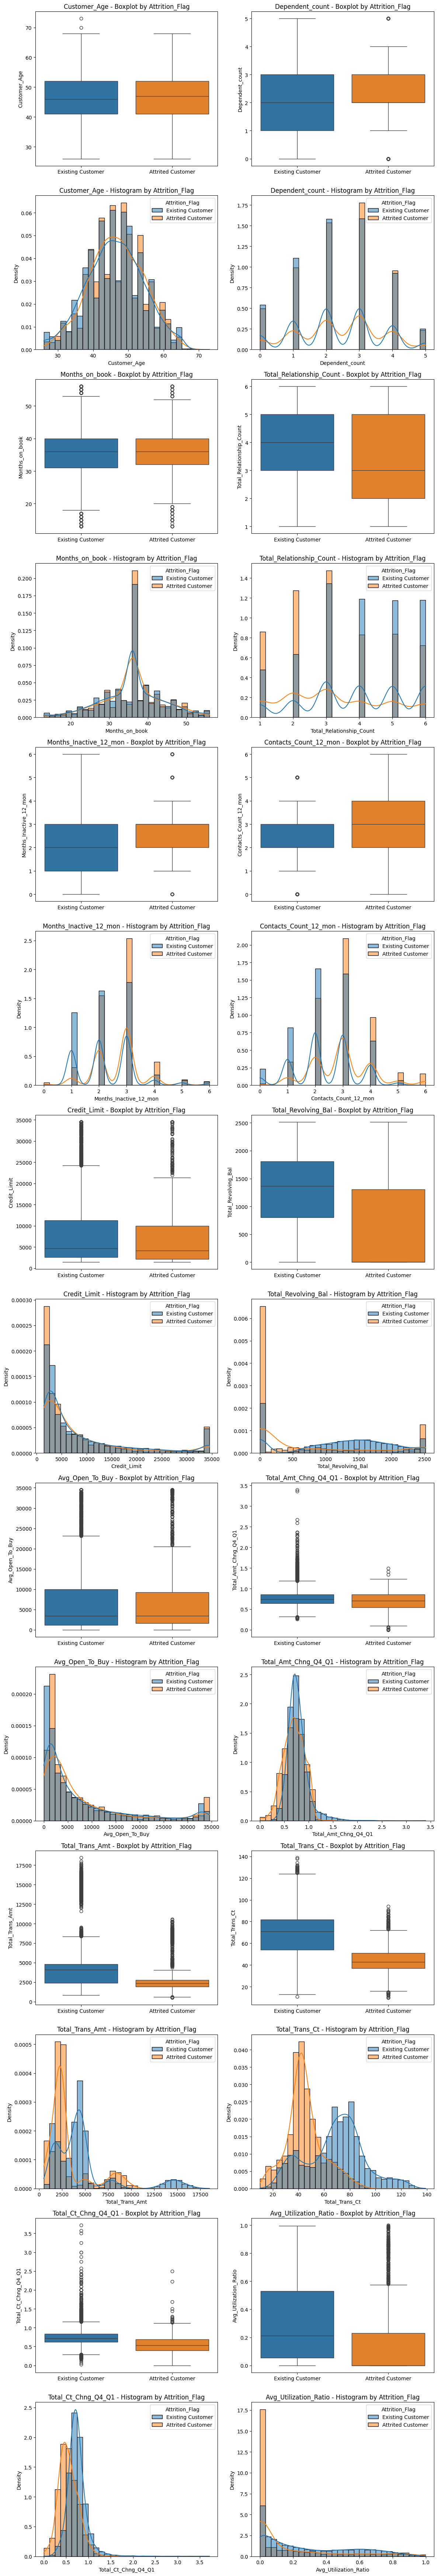

In [26]:
plot_box_and_hist_per_feature(data, hue_col='Attrition_Flag', cols_per_row=2, figsize_per_plot=(6, 5), bins=30, rotate_xticks=False)

#### 📊 Churn Insights by Numerical Feature (Grouped by Predictive Strength)

##### ✅ Strong Predictors

|         Feature             |        Most Churn-Prone Group        | Insight                                                  |
|----------------------------|:------------------------------------:|:----------------------------------------------------------|
| Total_Trans_Ct             | Low transaction count (<60)          | Strong predictor — low activity = high churn              |
| Total_Trans_Amt            | Low transaction amount (<5000)       | Lower spending = disengagement → higher churn             |
| Total_Ct_Chng_Q4_Q1        | Low change in transaction count      | No growth in behavior may signal disengagement            |
| Months_Inactive_12_mon     | Higher inactivity (3–4 months)       | Very strong churn indicator — inactivity is a red flag     |

##### 🟡 Moderate Predictors

|         Feature             |        Most Churn-Prone Group        | Insight                                                  |
|----------------------------|:------------------------------------:|:----------------------------------------------------------|
| Avg_Utilization_Ratio      | Low utilization (≤0.2)               | Underutilization may imply lack of need or interest       |
| Credit_Limit               | Low credit limit (<5000)             | Lower trust or fewer incentives to stay                   |
| Avg_Open_To_Buy            | Low open-to-buy (<5000)              | Mirrors credit limit pattern — less flexibility → churn   |
| Total_Relationship_Count   | Fewer relationships (1–2)            | Customers with fewer products are more likely to leave    |
| Months_on_book             | Longer tenure (>40 months)           | Long-timers might leave due to fatigue or better offers   |

##### ❌ Weak Predictors

|         Feature             |        Most Churn-Prone Group        | Insight                                                  |
|----------------------------|:------------------------------------:|:----------------------------------------------------------|
| Customer_Age               | Slightly older (50+)                 | Weak signal — minor shift toward older customers          |
| Dependent_count            | No clear pattern                     | Weak predictor — distribution nearly identical            |

### Categorical features - Bax and Bar Plots

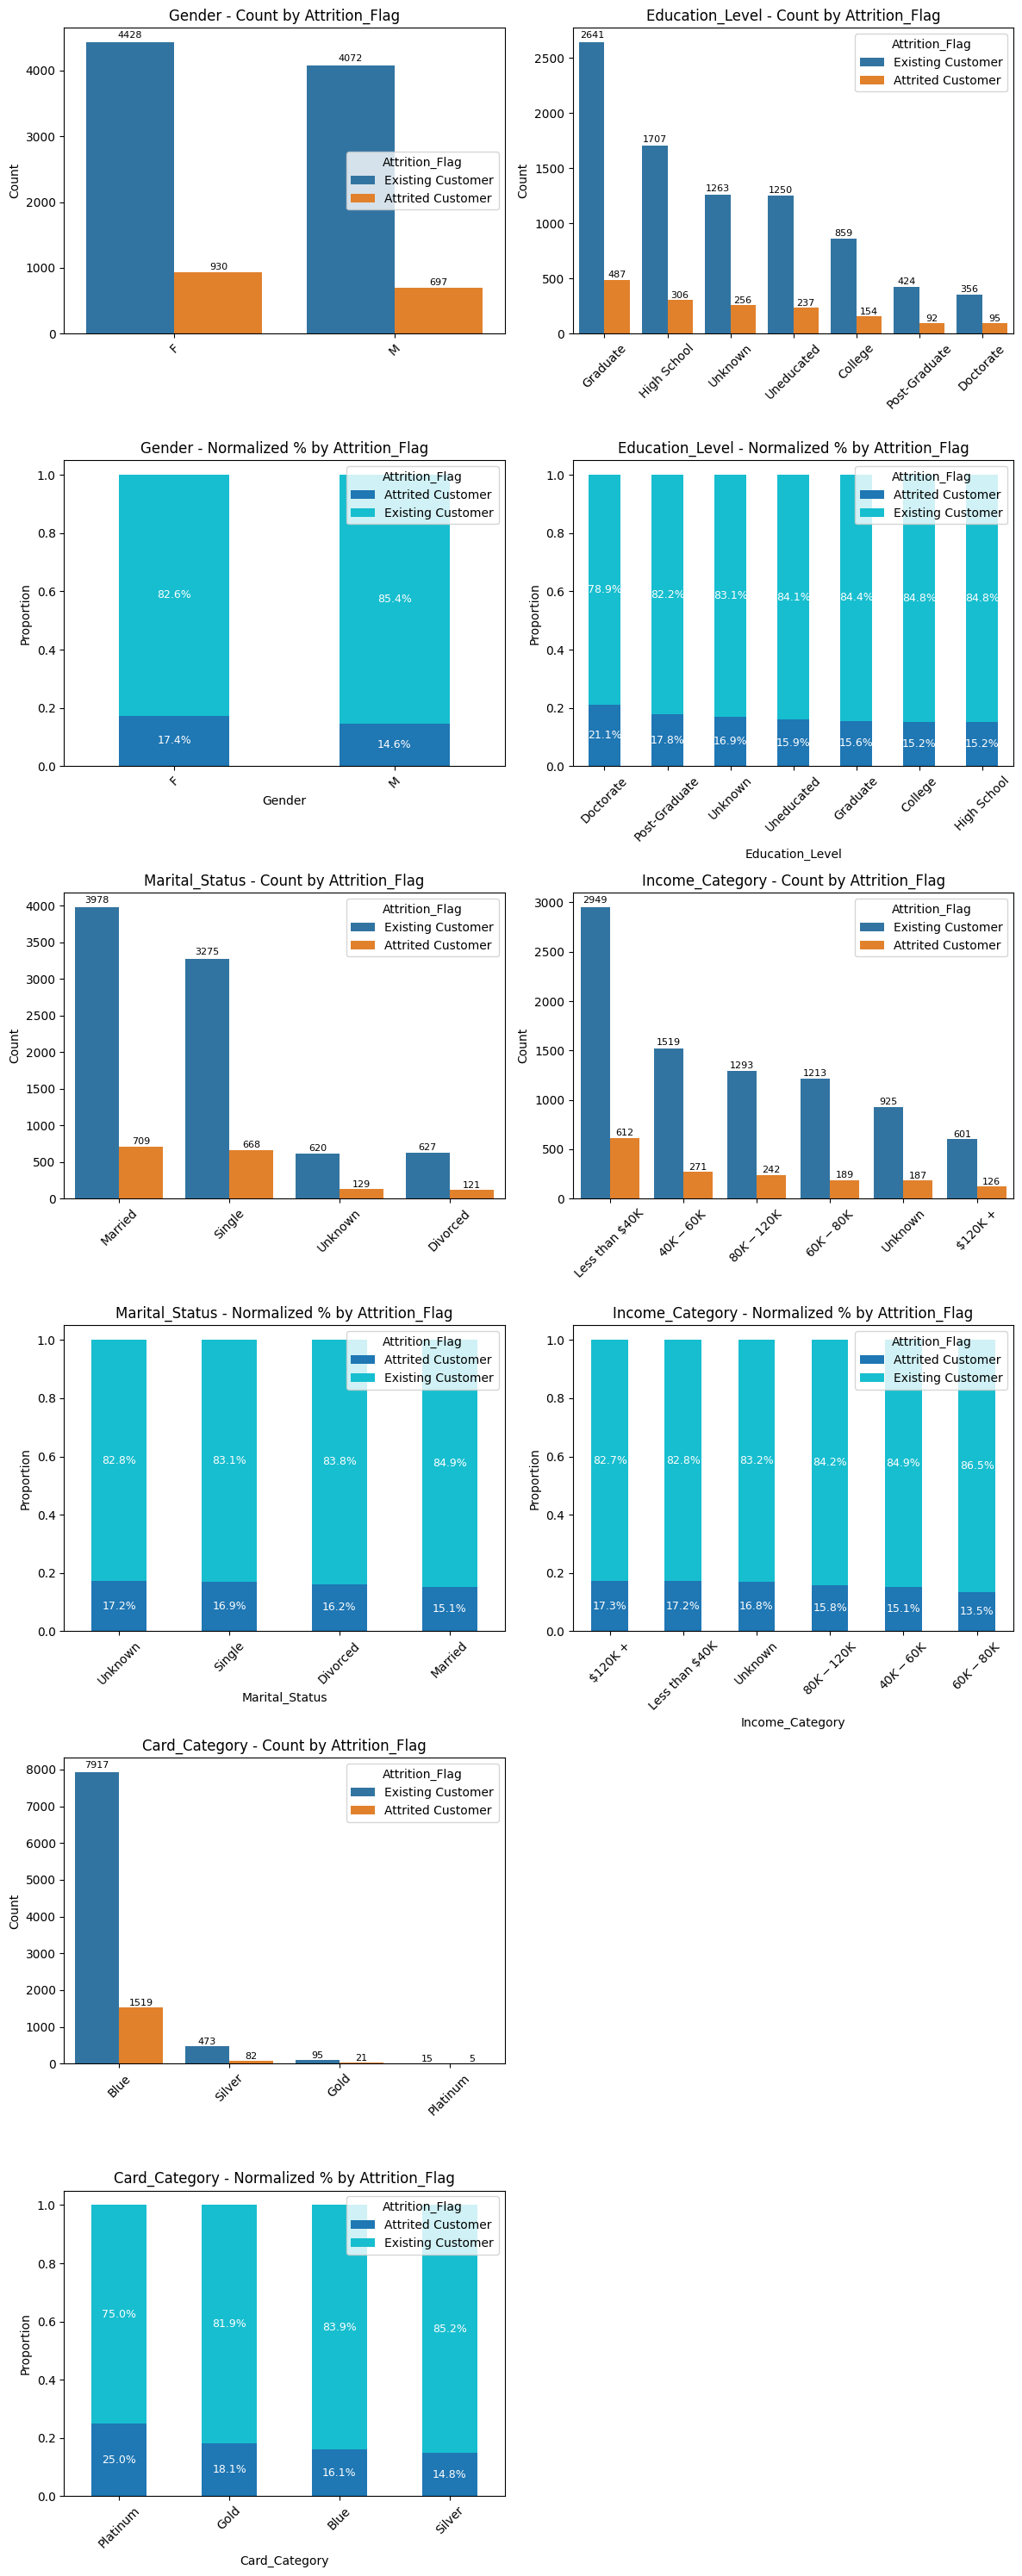

In [27]:
cat_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()
cat_norm_cols = [col for col in cat_cols if col != 'Attrition_Flag']
plot_bar_and_normalized_bars(data, cat_cols = cat_norm_cols, target_col='Attrition_Flag', cols_per_row=2, figsize_per_plot=(6, 5), rotate_xticks=True)

#### 📊 Categorical Churn Insights

| Feature         | Insights                                                              | Reasoning                                                                 |
|-----------------|------------------------------------------------------------------------------------------|---------------------------------------------------------------------------|
| Card Category   | 🔍 Modeling: Use **Platinum** (25% churn rate)<br>📊 Business: Focus on **Blue** (high volume) | Platinum has highest churn %; Blue has most actual churners               |
| Education       | 🔍 Modeling: Flag **Doctorate** (21.1%)<br>📊 Business: Monitor **Graduate** & **High School** | Doctorate churns more; larger volume comes from mid-education groups      |
| Marital Status  | 🔍 Modeling: Watch **Unknown** / **Divorced**<br>📊 Business: Focus on **Single** / **Married** | Unknown has highest churn %, but most churn cases are from larger groups (*Married* and *Single*)  |
| Income Category | 🔍 Modeling: Use **Unknown**, **<40K** and **>$120K** as high risk<br>📊 Business: Retain **$60K–$80K**       | Churn rate is higher at extremes; stable middle-income is large & loyal   |
| Gender          | ❌ Not useful for modeling or targeting                                                  | Very small difference in churn % between Female and Male                  |

## Correlation


📊 Plotting Correlation Matrix of Numerical Features...


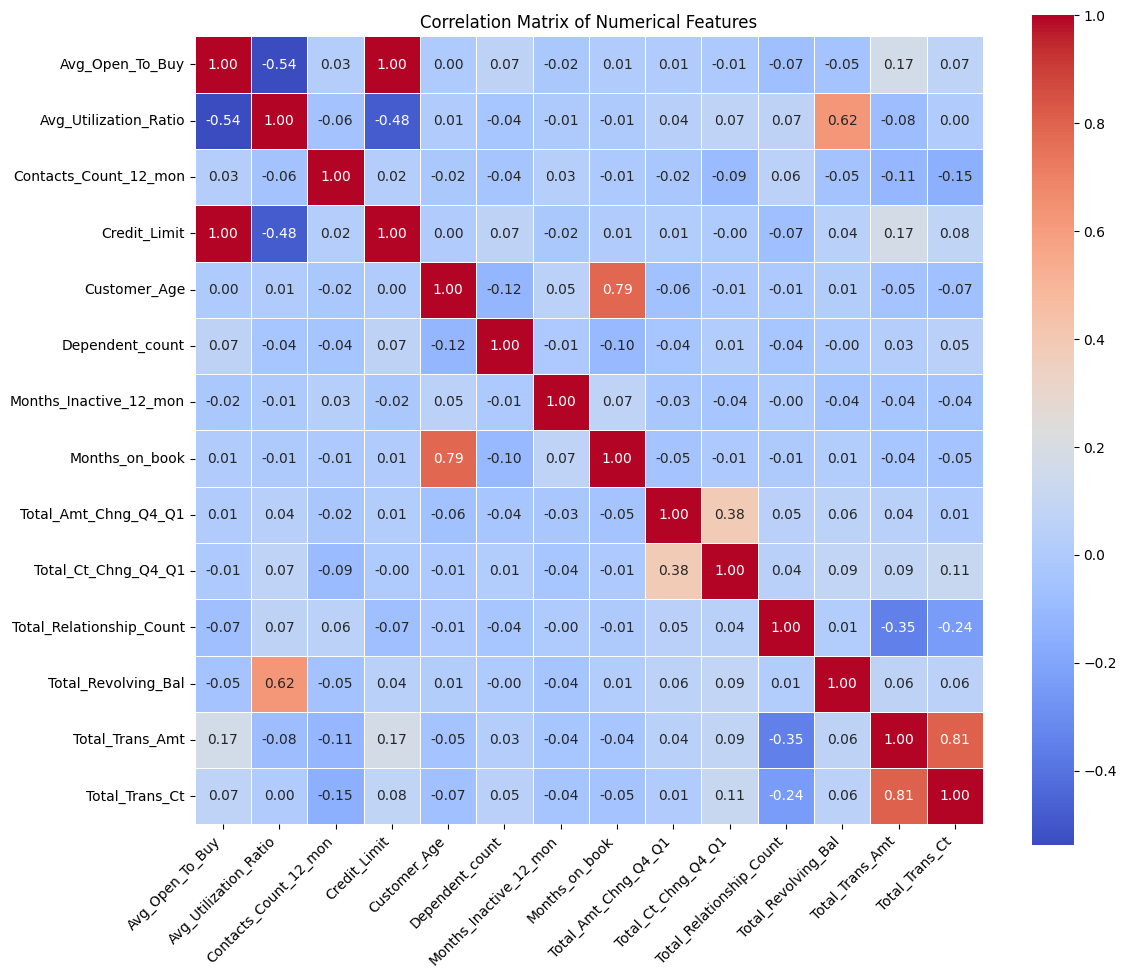

In [28]:
## columns are sorted by name
plot_corr_heat_map(data.reindex(sorted(data.columns), axis=1), figsize=(12, 10))

### 📊 Key Observations from the Correlation Matrix

#### Strong Correlation Pairs (|r| ≥ 0.7)

| Feature 1           | Feature 2           | Correlation | Notes                                              |
|---------------------|---------------------|-------------|----------------------------------------------------|
| Total_Trans_Ct      | Total_Trans_Amt     | **0.81**    | High transaction count drives higher spend         |
| Credit_Limit        | Avg_Open_To_Buy     | **1.00**    | Near-perfect correlation (could be redundant)      |
| Customer_Age        | Months_on_book      | **0.79**    | Older customers tend to have longer tenure         |

---

#### Moderate Correlation Pairs (0.3 ≤ |r| < 0.7)

| Feature 1               | Feature 2              | Correlation | Notes                                                    |
|-------------------------|------------------------|-------------|----------------------------------------------------------|
| Avg_Utilization_Ratio   | Total_Revolving_Bal    | **0.62**    | Higher balance increases utilization                     |
| Total_Amt_Chng_Q4_Q1    | Total_Ct_Chng_Q4_Q1    | **0.38**    | Changes in transaction amount align with count changes   |
| Total_Trans_Ct          | Total_Ct_Chng_Q4_Q1    | **0.35**    | Moderate correlation in behavioral activity              |

---

#### Negative Correlations to Watch

| Feature 1               | Feature 2              | Correlation | Notes                                                    |
|-------------------------|------------------------|-------------|----------------------------------------------------------|
| Avg_Utilization_Ratio   | Avg_Open_To_Buy        | **-0.54**   | Higher utilization means less open credit                |
| Avg_Utilization_Ratio   | Credit_Limit           | **-0.48**   | Larger credit limits reduce utilization ratio            |
| Total_Trans_Ct          | Total_Relationship_Count | **-0.24** | Slight inverse — possibly due to product usage patterns  |


* For highly correlated features, we need to select one to avoid multicollinearity in logistic regression. 
* However, this redundancy may not need to be addressed when using tree-based models.

# Feature Engineering
----

After reviewing the features using histograms and box plots, we can apply a log transformation to see if it improves model performance.

| Feature                  | Log Transform? | Why                                         |
|--------------------------|:-------------:|---------------------------------------------|
| Credit_Limit             | ✅             | Heavily right-skewed, wide numeric range    |
| Total_Revolving_Bal      | ✅             | Strong right skew, many small, few large    |
| Avg_Open_To_Buy          | ✅             | Mirrors Credit_Limit                        |
| Total_Trans_Amt          | ✅             | Right skew, wide range                      |
| Total_Trans_Ct           | ✅             | Right skew, wide range                      |
| Others                   | ❌             | No strong skew, discrete, or bounded        |


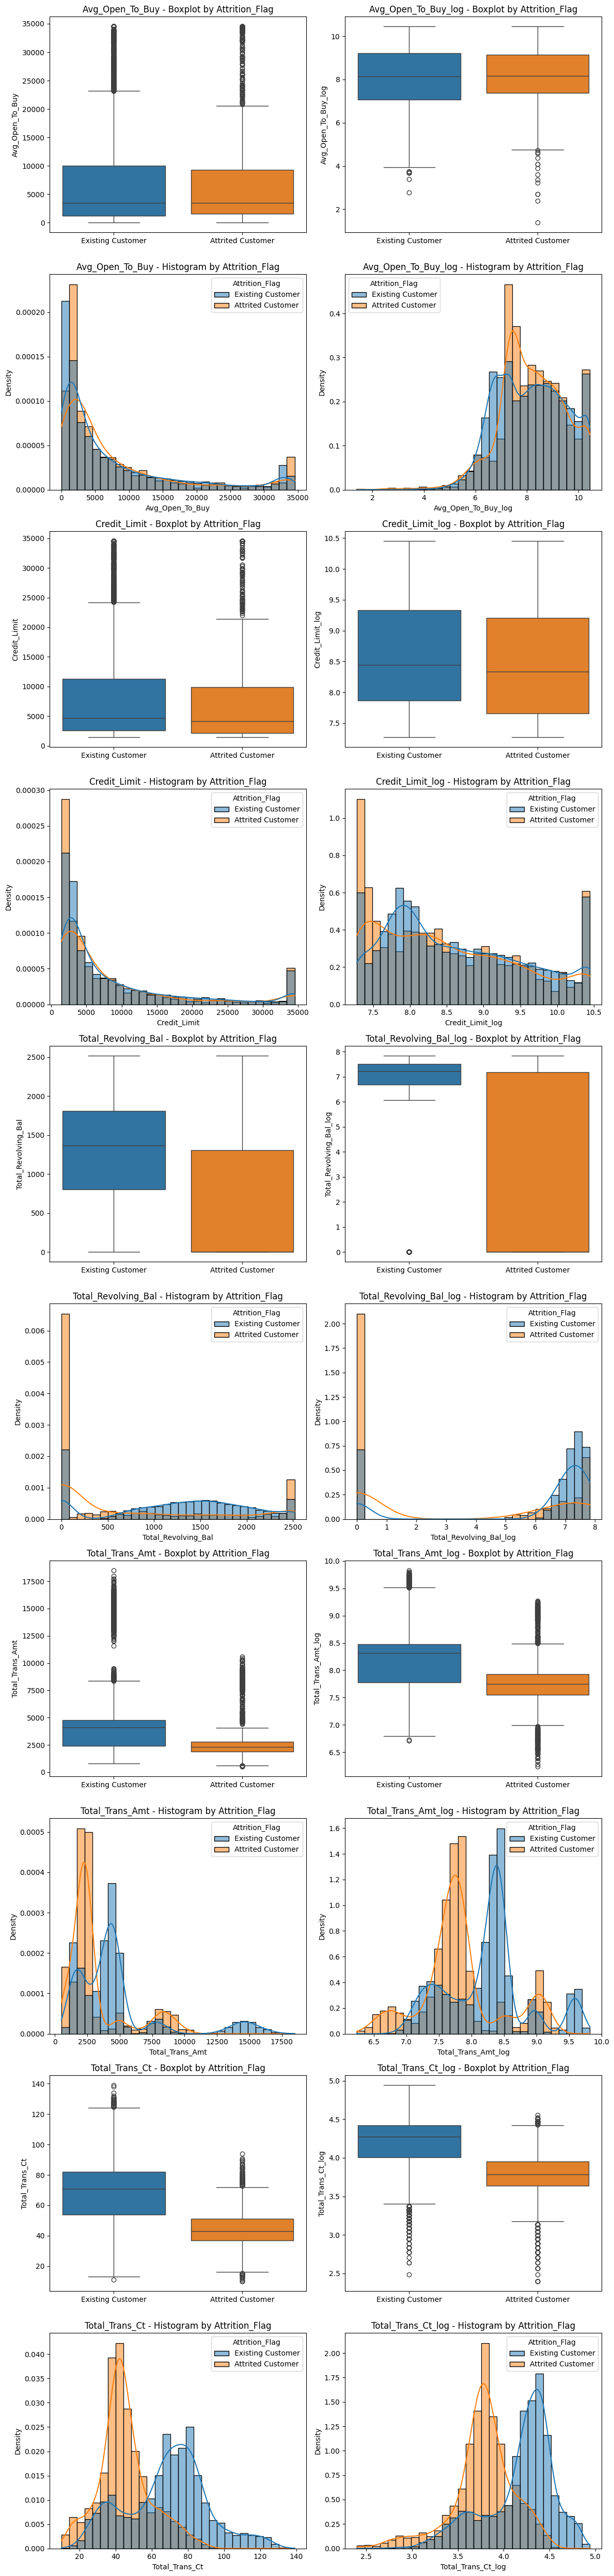

In [29]:
## log transformation
log_features = [
    'Credit_Limit',
    'Total_Revolving_Bal',
    'Avg_Open_To_Buy',
    'Total_Trans_Amt',
    'Total_Trans_Ct'
]

data_log = data.copy()


data_log[[f + '_log' for f in log_features]] = data_log[log_features].apply(np.log1p)

## compare features pre- and after log

compare_log_features = ['Attrition_Flag'] + log_features + [col for col in data_log.columns if col.endswith('_log')]

compare_log_features = sorted(compare_log_features)

# Plot log-transformed features
plot_box_and_hist_per_feature(data_log[compare_log_features], hue_col='Attrition_Flag', cols_per_row=2, figsize_per_plot=(6, 5), bins=30, rotate_xticks=False)

✅ After log:
* Histograms look more bell-shaped (closer to normal).
* Boxplots show reduced effect of outliers.
* In several features, the difference between churned and non-churned groups is more interpretable (and easier for a linear model to “see”).


## Correlation heat map


📊 Plotting Correlation Matrix of Numerical Features...


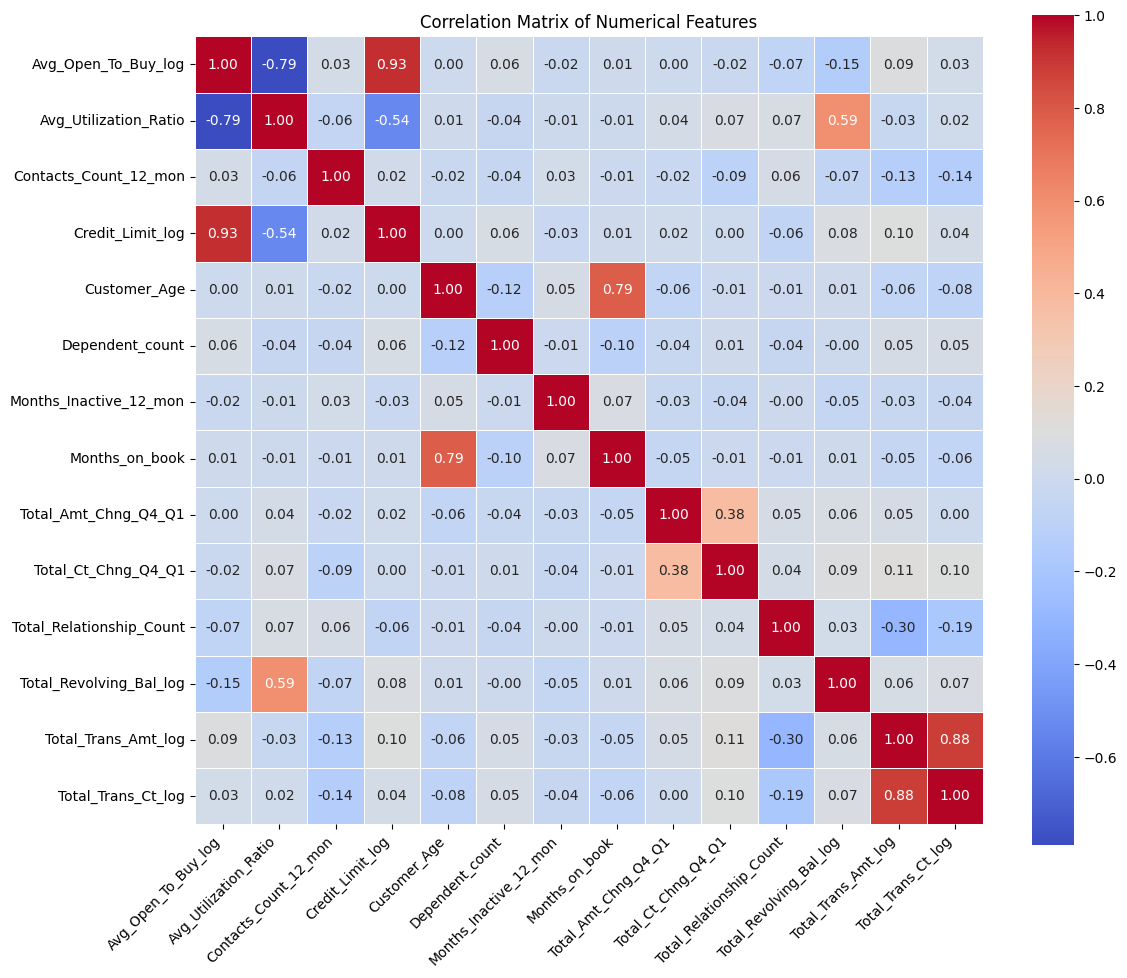

In [30]:
## get all features: log-transformed and original without those which are log-transformed
all_features = [col for col in data.columns if col not in log_features] + [col + '_log' for col in log_features]

## plot correlation matrix
plot_corr_heat_map(data_log[all_features].reindex(sorted(data_log[all_features].columns), axis=1), figsize=(12, 10))

### Log Transformation & Correlation Analysis

After applying log transformation to right-skewed features, the overall structure of feature correlations remains similar. This is expected, as Pearson correlation measures linear associations, and monotonic log transforms typically preserve the order of values. Highly correlated feature pairs before log (e.g., `Credit_Limit` & `Avg_Open_To_Buy`) remain highly correlated after log transformation.

Log transformation, however, does make distributions more normal and models more stable—even if correlations do not change dramatically.

# Machine Learning Models

## Logistic Regression

*Training on data with feature engineering (log transformation).*

In [31]:
## Split train and test data
data_new = data_log[all_features]

search_new, X_test_new, y_test_new, y_pred_new, y_proba_new, cat_cols_new, num_cols_new = train_logreg_pipeline(data=data_new)

Best parameters: {'logreg__C': 0.19780827689353775, 'logreg__penalty': 'l1'}
Best CV ROC AUC: 0.9235092566516713

Test ROC AUC: 0.9154379776601999
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1701
           1       0.81      0.55      0.66       325

    accuracy                           0.91      2026
   macro avg       0.86      0.76      0.80      2026
weighted avg       0.90      0.91      0.90      2026



## Random Forest

*Training on original data.*

In [32]:
search_rf, X_test_rf, y_test, y_pred_rf, y_proba_rf, cat_cols_rf, num_cols_rf = train_rf_pipeline(
    data,
    target_col='Attrition_Flag',
    test_size=0.2,
    random_state=42,
    n_iter=20,
    n_splits=10
)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best parameters: {'rf__n_estimators': 300, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 2, 'rf__max_features': 'log2', 'rf__max_depth': 30, 'rf__bootstrap': False}
Best CV ROC AUC: 0.9875820579783149

Test ROC AUC: 0.9835318590874147
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1701
           1       0.95      0.77      0.85       325

    accuracy                           0.96      2026
   macro avg       0.95      0.88      0.91      2026
weighted avg       0.96      0.96      0.96      2026



## XGBoost

*Training on data with feature engineering (log transformation) and applying the SMOTE upscaling method.*

In [33]:
## XGBoost with Log transformation
search_xgb_smote_log, X_test_xgb_smote_log, y_test_xgb_smote_log, y_pred_xgb_smote_log, y_proba_xgb_smote_log, cat_cols_xgb_smote_log, num_cols_xgb_smote_log = train_xgb_pipeline_with_smote(data=data_new)


Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best parameters: {'xgb__subsample': 0.8, 'xgb__reg_lambda': 0.1, 'xgb__reg_alpha': 0, 'xgb__n_estimators': 300, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.31622776601683794, 'xgb__gamma': 0, 'xgb__colsample_bytree': 1.0}
Best CV ROC AUC: 0.9929274132454466

Test ROC AUC: 0.9919070230181342
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1701
           1       0.95      0.87      0.91       325

    accuracy                           0.97      2026
   macro avg       0.96      0.93      0.95      2026
weighted avg       0.97      0.97      0.97      2026



# Get best model

📌 By comparing the best cross-validated ROC-AUC scores, the XGBoost model with feature engineering shows the best performance.


🔍 Top Coefficients / Feature Importance:

                         Feature  Coefficient
0             Total_Trans_Ct_log     0.154542
1                       Gender_M     0.093383
2       Total_Relationship_Count     0.069568
3                       Gender_F     0.066195
4         Marital_Status_Married     0.062211
5         Months_Inactive_12_mon     0.056174
6        Total_Revolving_Bal_log     0.053957
7       Education_Level_Graduate     0.052471
8          Contacts_Count_12_mon     0.046675
9          Marital_Status_Single     0.037645
10   Income_Category_$60K - $80K     0.032518
11   Income_Category_$40K - $60K     0.025687
12       Education_Level_College     0.024105
13           Total_Trans_Amt_log     0.023317
14           Total_Ct_Chng_Q4_Q1     0.022022
15               Dependent_count     0.020562
16   Education_Level_High School     0.019104
17       Income_Category_Unknown     0.017660
18  Income_Category_$80K - $120K     0.016988
19    Education_Level_Uneducated     

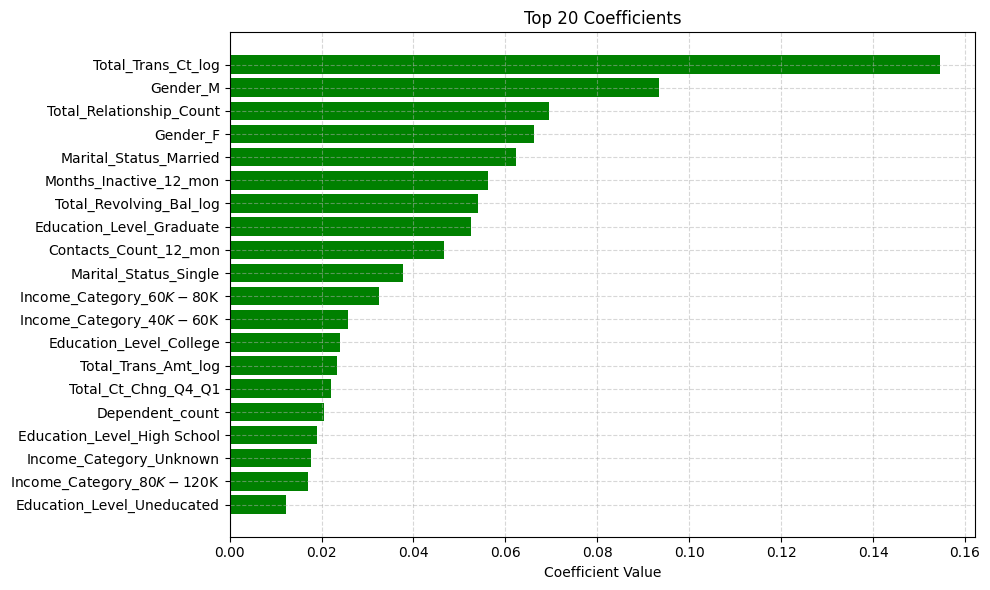


📊 Plotting Confusion Matrix...


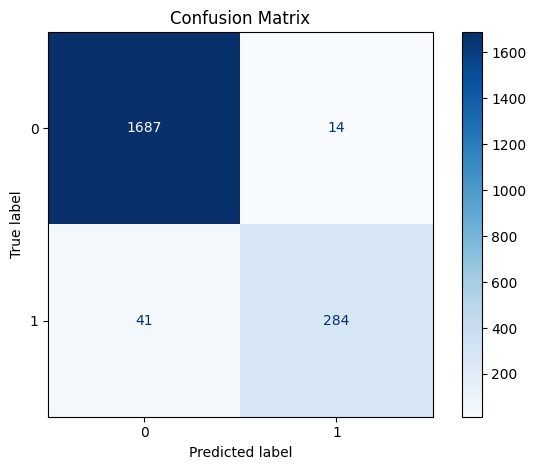

✅ Accuracy:  0.973
✅ Precision: 0.953
✅ Recall:    0.874
✅ F1 Score:  0.912

📊 Plotting ROC Curve...


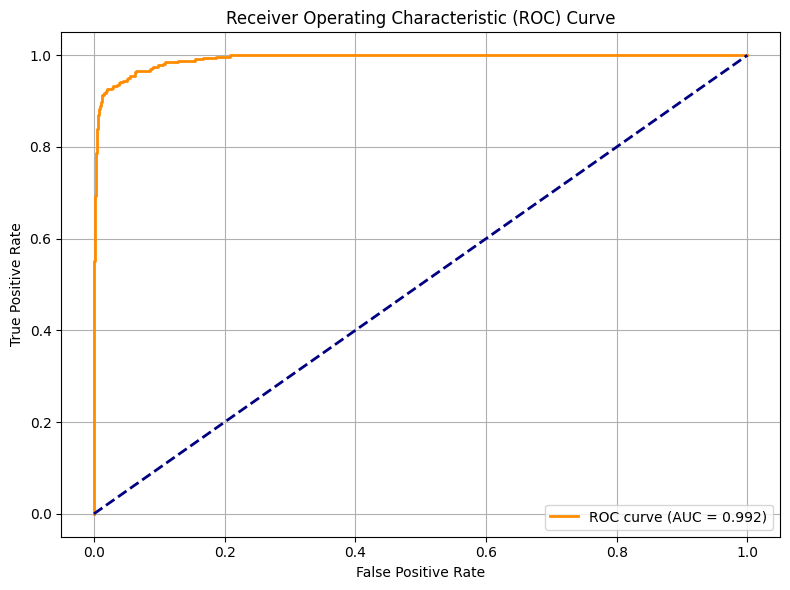


📊 Plotting Precision-Recall Curve...


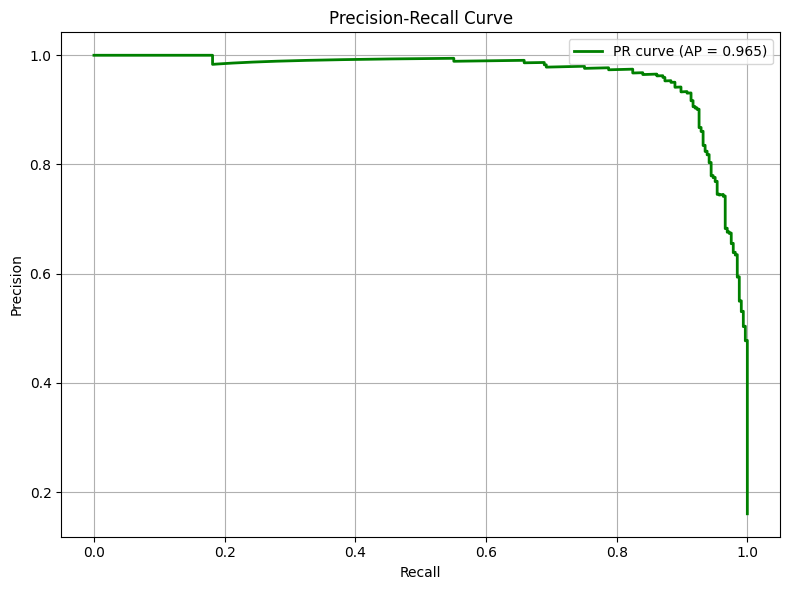

In [34]:
## get best model
best_model_xgb_smote_log, importance_xgb_smote_log, all_feature_names_xgb_smote_log = get_best_model(search_xgb_smote_log, cat_cols_xgb_smote_log, num_cols_xgb_smote_log, named_step='xgb')
plot_metrics(y_test_xgb_smote_log, y_pred_xgb_smote_log, y_proba_xgb_smote_log, importance_xgb_smote_log, best_model_xgb_smote_log, all_feature_names_xgb_smote_log, top_n=20)


# 🧪 Model Performance Summary & Interpretation

| Emsemble Tree         | Version                     | ROC-AUC (Test) | Accuracy | Precision | Recall | F1 Score |
| --------------------- | --------------------------- | :------------: | :------: | :-------: | :----: | :------: |
| 🌟 Logistic Regression | Feature engineering         |     0.9154     |  0.907   |   0.810   | 0.551  |  0.656   |
| 🌟 RF                  | Regular                     |     0.9835     |  0.957   |   0.951   | 0.772  |  0.852   |
| 🌟 XGB                 | Feature engineering + SMOTE |     0.9919     |  0.973   |   0.953   | 0.874  |  0.912   |


## 💡 Key Insights

### **Logistic Regression**
- Logistic regression with feature engineering provides a solid baseline, achieving a **ROC-AUC** of **0.9154** and an **accuracy** of **0.907**. However, its **recall** (**0.551**) and **F1 score** (**0.656**) indicate it struggles more than tree ensembles to correctly identify churners in this imbalanced dataset.


### **Random Forest (RF)**
- The baseline Random Forest model (no feature engineering, no SMOTE) achieved an excellent **ROC-AUC** of **0.9835**, with strong **precision** (**0.951**) and **F1** (**0.852**) scores.  
  Its **recall** (**0.772**) is a significant improvement over logistic regression, but still trails the best XGBoost variants..

  *Interpretation:* Random Forest is highly effective out-of-the-box for churn prediction, especially at minimizing false positives, but may miss a higher proportion of true churners compared to the optimal boosted model.

---

### **XGBoost (XGB)**
- The XGBoost model with **feature engineering** and **SMOTE** stands out with the best overall performance:
    - **ROC-AUC:** **0.9919**  
    - **Precision:** **0.953**  
    - **Recall:** **0.874**  
    - **F1 Score:** **0.912**  
  This model achieves the best trade-off between capturing true churners and minimizing false positives.

  *Interpretation:* XGBoost with these enhancements is the top performer, making it ideal for high-value churn prevention where both sensitivity and precision matter.

---

## ❕ Why These Metrics Matter

- **ROC-AUC** measures the model’s ability to distinguish churners from non-churners, even in highly imbalanced datasets.
- **F1 Score** balances precision (how many predicted churners are actually churners) and recall (how many actual churners are caught), providing a single metric for model selection.
- **Precision & Recall** directly affect business outcomes: high recall captures more at-risk customers, while high precision ensures resources aren’t wasted on false positives.

---

## 💰 Business Implications

- Deploying **XGBoost with feature engineering and SMOTE** is projected to improve churn capture (recall) by over **10 percentage points** compared to standard Random Forest (0.874 vs 0.772), **with no sacrifice in precision**.
    - For businesses with large customer bases, this can translate to substantial revenue retention and smarter allocation of retention marketing.
    - **Example:** For every 1% reduction in churn, if the average customer is worth \$X, the improved recall from XGBoost could mean \$Y in extra retained revenue each year.


---

## 🛠 Model Monitoring & Next Steps

- **Continuous Monitoring:**  
  Track model performance post-deployment to identify data drift or changes in churn behavior.
- **Threshold Optimization:**  
  Adjust classification thresholds as business objectives shift (e.g., prioritize recall for aggressive retention or precision for cost control).
- **Explainability:**  
  Use feature importance and SHAP values to drive actionable business insights and build stakeholder trust.
- **Periodic Retraining:**  
  Regularly update and validate the model with fresh data to ensure continued high performance.

---

## ✅ Final Recommendation

> **XGBoost with feature engineering and SMOTE is recommended as the production model for customer churn prediction, offering the best balance of accuracy, recall, and business impact.**  

> Ongoing evaluation, explainability checks, and retraining should be integral to the ML operations workflow.

---

# Extra

# Plot Shap values 
SHAP shows how much each feature contributes to the prediction for each individual row/customer—perfect for explaining decisions to stakeholders and regulators, not just “globally” but customer by customer.

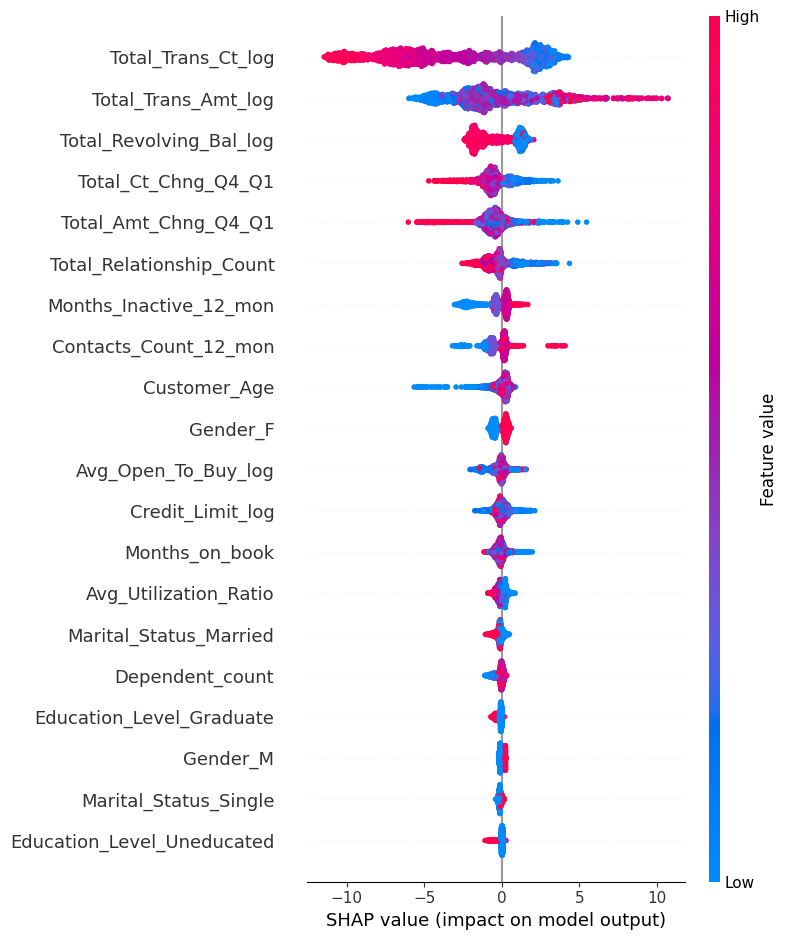

In [35]:
explainer, shap_values = plot_tree_ensemble_shap(best_model_xgb_smote_log, X_test_xgb_smote_log, all_feature_names_xgb_smote_log, model_step="xgb")

> This chart shows, for every customer, how each feature is pushing the model’s churn prediction up or down. The most important factors are transaction count and transaction amount—customers who transact more are much less likely to churn. Inactivity periods and relationship count are also major risk drivers. These insights highlight where retention programs can focus: boost customer engagement and reduce inactivity.

> •	Customers who have higher total transaction amount are, according to the model, actually more likely to churn (all else equal).
	
> •	At the same time, higher transaction count (more frequent transactions) means they’re less likely to churn.

> Some customers might make a few huge transactions, but not be frequent users. They drop big money once in a while, but don’t build a habitual relationship with your service.
*	If they churn, our model learns that “big spend, but not often” = risk.
* Others might make many small, regular transactions—habitual, engaged users. The model sees that “lots of frequent activity” = loyal.
* The two features are related, but not perfectly correlated.
* Someone could have a high total amount with few transactions (e.g., 2 big purchases), while another has lots of small transactions.
* The model picks up these subtle differences!

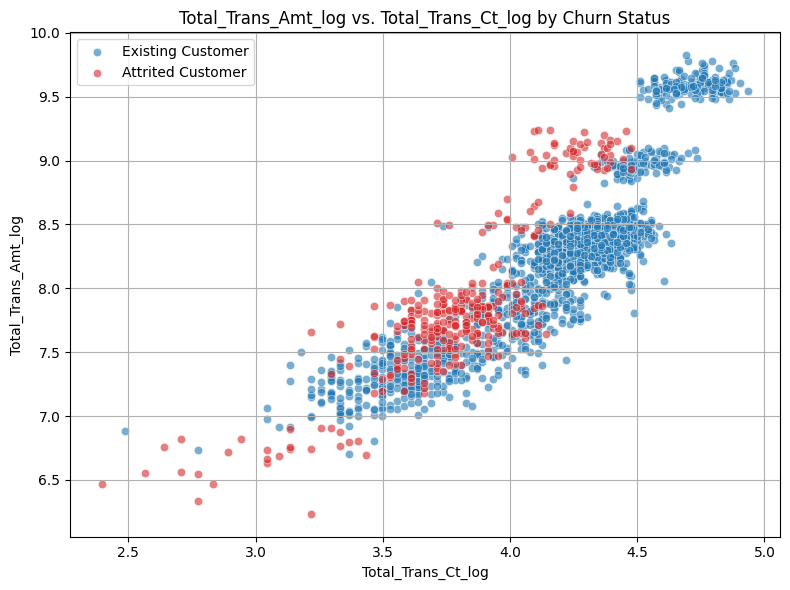

In [36]:
scatter_plot(X_test_xgb_smote_log, y_test_xgb_smote_log, x_col="Total_Trans_Ct_log", y_col="Total_Trans_Amt_log")

The scatter plot confirms that customers with frequent and higher-value transactions almost never churn, while churners are overwhelmingly those with low transaction counts and amounts. The strongest predictor of loyalty is engagement frequency, not just spend.



View churn or non-churn shap value
---

In [37]:
# Make sure y_test is aligned with your X_test/shap_values index
churn_indices = y_test_xgb_smote_log[y_test_xgb_smote_log == 1].index
nonchurn_indices = y_test_xgb_smote_log[y_test_xgb_smote_log == 0].index

# Pick one example of each (use .iloc[0] if Series, or .index[0] if index)
idx_churn = churn_indices[0]
idx_nonchurn = nonchurn_indices[0]

# If shap_values is a list (e.g., from multiclass), pick the correct class
if isinstance(shap_values, list):
    # For binary, usually shap_values[1] is the "churn" class
    shap_arr = shap_values[1]
else:
    shap_arr = shap_values

# Find the relative index of these samples in your X_test (since .index might be non-0-based)
ix_churn = list(X_test_xgb_smote_log.index).index(idx_churn)
ix_nonchurn = list(X_test_xgb_smote_log.index).index(idx_nonchurn)

shap_churn = shap_arr[ix_churn]
shap_nonchurn = shap_arr[ix_nonchurn]

In [38]:
# Compare SHAP values

df_compare = pd.DataFrame({
    "Feature": all_feature_names_xgb_smote_log,
    "SHAP_Churn": shap_churn,
    "SHAP_NonChurn": shap_nonchurn
})
df_compare["Abs_Diff"] = (df_compare["SHAP_Churn"] - df_compare["SHAP_NonChurn"]).abs()
df_compare.sort_values("Abs_Diff", ascending=False, inplace=True)
df_compare.head(10)  # Top 10 most different features

,Feature,SHAP_Churn,SHAP_NonChurn,Abs_Diff
13,Total_Trans_Ct_log,-1.501826,-5.072021,3.570195
10,Total_Revolving_Bal_log,0.990630,-1.349649,2.340278
4,Months_Inactive_12_mon,-2.481131,-0.479921,2.001209
12,Total_Trans_Amt_log,0.779849,-0.687170,1.467019
6,Total_Amt_Chng_Q4_Q1,0.019103,1.129308,1.110205
0,Customer_Age,0.018649,-0.801980,0.820629
3,Total_Relationship_Count,-1.556329,-0.980495,0.575834
21,Education_Level_Uneducated,-0.002327,-0.553259,0.550931
5,Contacts_Count_12_mon,-0.214589,-0.704717,0.490128
31,Income_Category_Less than $40K,0.126686,-0.220043,0.346729


In [39]:
shap.initjs()

# Force plot for churn customer
shap.force_plot(
    explainer.expected_value, shap_churn, feature_names=all_feature_names_xgb_smote_log
)


In [40]:

# Force plot for non-churn customer
shap.force_plot(
    explainer.expected_value, shap_nonchurn, feature_names=all_feature_names_xgb_smote_log
)

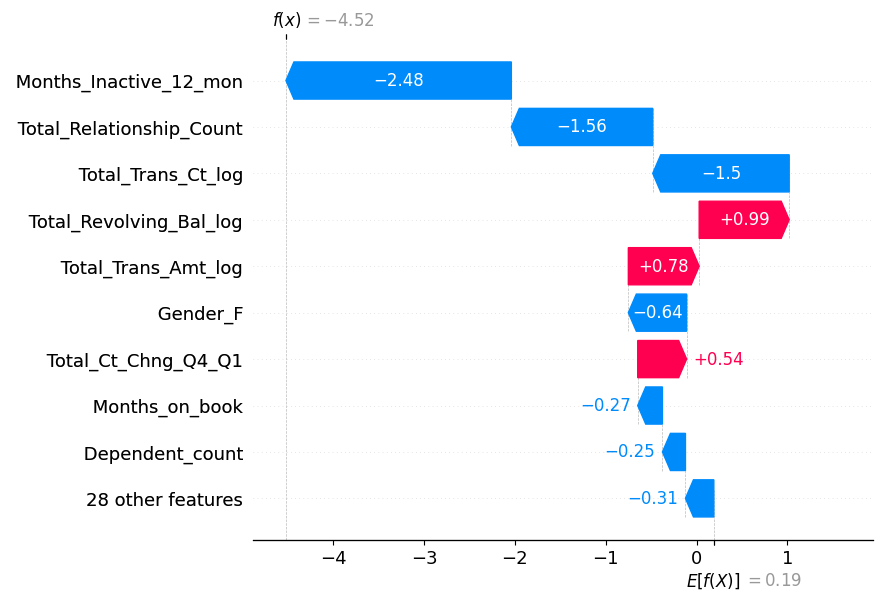

In [41]:
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value, shap_churn, pd.Series(shap_churn, index=all_feature_names_xgb_smote_log)
)


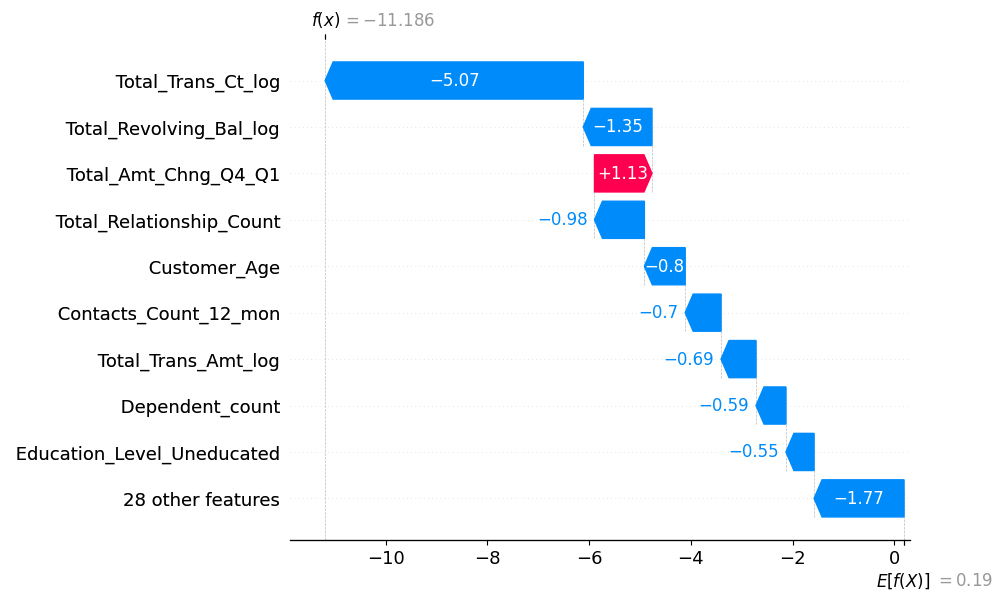

In [42]:
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value, shap_nonchurn, pd.Series(shap_nonchurn, index=all_feature_names_xgb_smote_log)
)

## 🔍 SHAP Waterfall Interpretation: Individual Prediction

### **Customer Profile:** [Churned / Not Churned]

#### **Model Output**
- **Predicted class:** [Churn / Not Churn]
- **Model output (log-odds or probability):** [e.g., f(x) = -4.52]
- **Baseline (average for all customers):** [E[f(X)] = 0.19]

---

### **Top Features Driving the Prediction**

Given the first Shap plot as an example:

| Feature                  | SHAP Value | Effect        |  Business Interpretation                              |
|--------------------------|------------|---------------|------------------------------------------------------|
| Months_Inactive_12_mon   |   -2.48    | Risk↑         |  High inactivity increases churn risk                 |
| Total_Relationship_Count |   -1.56    | Risk↑         |  Fewer products/relationships, less stickiness        |
| Total_Trans_Ct_log       |   -1.50    | Risk↑         |  Low transaction count, less engagement               |
| Total_Revolving_Bal_log  |   +0.99    | Risk↓         |  High revolving balance, potential loyalty signal     |
| Total_Trans_Amt_log      |   +0.78    | Risk↓         |  Higher transaction amount, lowers risk               |
| Gender_F                 |   -0.64    | Risk↓       |  Effect of gender in model                            |
| Total_Ct_Chng_Q4_Q1      |   +0.54    | Risk↓         |  Stable or growing engagement reduces risk            |
| ...                      |   ...      | ...           |  ...                                                  |

*Positive SHAP values push toward churn, negative values push toward retention. The magnitude indicates how much each feature contributed.*

---

### **Narrative Summary**

- The **main drivers increasing churn risk** for this customer are:
  - High months of inactivity
  - Fewer relationships/products
  - Low transaction count

- **Factors helping retention** include:
  - High revolving balance
  - Above-average transaction amount
  - Positive recent change in transactions

**Business Takeaway:**  
> This customer is flagged as a churn risk primarily due to inactivity and declining engagement. To retain them, focus on re-engagement campaigns and encourage more frequent interactions.

---

### **Visual Summary**
The model makes its decision by adding up how each feature moves the prediction toward or away from churn. For this churn customer, high inactivity and low transaction count were the biggest drivers of risk—even though some spending and balance features helped. For the non-churn customer, frequent transactions, high engagement, and long tenure made the model nearly certain they’ll stay, despite one or two risk flags.

* What’s most useful here?
  * We can tell a customer why they’re at risk (and what to target to keep them!).
  * For retention: Target customers with rising inactivity and dropping transaction count.
  * For reassurance: Customers with high engagement and relationship counts are safest.